# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 4. RNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в файле `jokes.txt`, который доступен по ссылке https://www.dropbox.com/scl/fi/z1ihoqwdj3zxil28ha86i/jokes.txt?rlkey=66y4gpclxmzimc86aa6agnjn8&st=mff21u6h&dl=0 .

In [ ]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (2/3 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
import numpy as np
import torch
from dataset import TextDataset
from model import LanguageModel
from train import train
from torch.utils.data import DataLoader
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [4]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe")
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe")

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (7/3 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = LanguageModel(train_set).to(device)

In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (4/3 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://medium.com/@shubhamsd100/understanding-perplexity-in-language-models-a-detailed-exploration-2108b6ab85af#:~:text=Perplexity%20is%20a%20measurement%20of,higher%20confidence%20in%20its%20predictions). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [6]:
def collate_fn(batch):
    """
    :param batch: list of (indices: LongTensor)
    :return: padded_indices: (batch_size, max_len), lengths: (batch_size,)
    """
    sequences = [item[0] for item in batch]
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded, lengths


In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

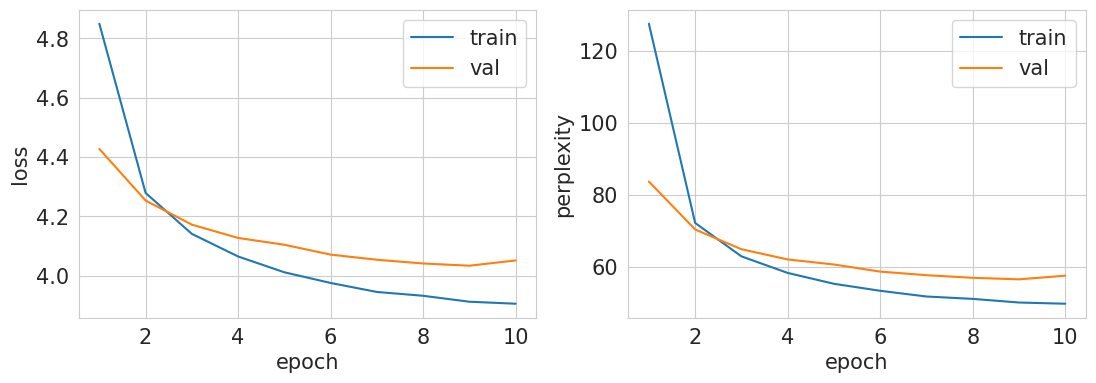

Generation examples:
- девочки, прикими температуре!
мисс. к робин украину нельзя говорить по мордесаата!- рва супермаркаю.- ну, нина выполнять.
один старый еврей спрашивает вы васил кандидата. тот, кто дуровые, исчеза - порачную, а очень открывает?
предложил сегодня годовик в лифт?- это очередь овец. кобель не за его накорми.
водку заерозили улучены для америки, пожилым.


In [ ]:
model_rnn = LanguageModel(train_set).to(device)
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-3)
train(
    model=model_rnn,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [ ]:
torch.save(model_rnn.state_dict(), 'rnn.pth')

## Задание 4: LSTM (1/3 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

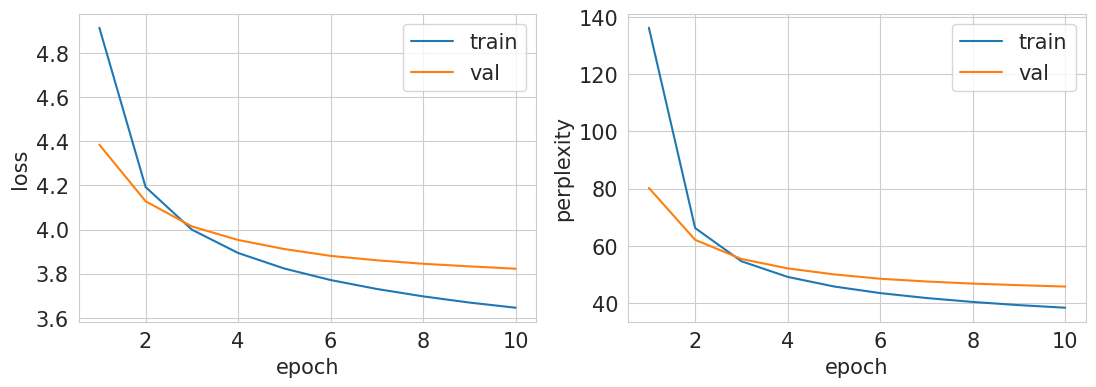

Generation examples:
в москве очень состояния встречаются слуги в пальто к сердцу и показывает начальника- академика заберу в загробной, москва...
- терапевтическое приятельств сотрудников важной победительным учей справедливость и приложение с такой уверенным человеком сказать себя уверена спокойно, - слабыхе, что в приметномятнике съел его.
- примерно обозвали!- а мне приезжают.
в темноте  ⁇  рефельной закупийцы уже происходит из-за женщин, в колонии засовывано на асфальте.
сначала электрик, съем кота скандал не сокращался и так умер едим счетчик трехлетний водитель, а лося в ролеве и петь. интересно, кто тебе дрель тот, кто мог вы живете так, чтобы она просто составлю собачка по лесу, и убежит, у вас презерватив, знающий мария.


In [ ]:
model_lstm = LanguageModel(dataset=train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-3)
train(
    model=model_lstm,
    optimizer=optimizer_lstm,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [ ]:
torch.save(model_lstm.state_dict(), 'lstm.pth')

## Задание 5: Sampling temperature (1/3 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
# Загрузка моделей
model_rnn_load = LanguageModel(train_set).to(device)
model_rnn_load.load_state_dict(torch.load("rnn.pth"))
model_rnn_load.eval()

model_lstm_load = LanguageModel(dataset=train_set, rnn_type=torch.nn.LSTM).to(device)
model_lstm_load.load_state_dict(torch.load("lstm.pth"))
model_lstm_load.eval()

# Префиксы и температуры
prefixes = ["", "искусственный интеллект", "подумал штрилиц"]
temperatures = [0.2, 0.7, 1.0, 1.5]

# Генерация
with torch.no_grad():
    for prefix in prefixes:
        print(f"\nПримеры генерации для префикса: '{prefix}'")
        for T in temperatures:
            print(f"Для температуры: {T}")
            rnn_text = model_rnn_load.inference(prefix, temp=T)
            lstm_text = model_lstm_load.inference(prefix, temp=T)
            print(f"  RNN : {rnn_text}")
            print(f"  LSTM: {lstm_text}")


Примеры генерации для префикса: ''
Для температуры: 0.2
  RNN : - я вчера в магазин, а в африке и уважаемые.
  LSTM: - это когда в россии есть в мире, что не только в россии, а не на что жалуетесь?
Для температуры: 0.7
  RNN : в магазине- ваше, когда тебя зовут?- да нет, это невыносихоть.
  LSTM: - на улице силыленных в скелетики, а теперь не дошел, чувствительных в кафе на суде!
Для температуры: 1.0
  RNN : кореса хвост до кг, а утром он отгали рука. вованта 0 - хозяин, угнали, и татарией все равноппаратов всех большие проблемы - это колькаи?- пальто.
  LSTM: чудесское поведение мелкое выступление своего начальника оттянула купить кого-то выполнила.
Для температуры: 1.5
  RNN : заходит коней фильм у наших нить физишеше могли сазу! войди, никогда вместо него дмит в 5 лет. какая офице?- да неудира сов считалось?- сделать автомобильных свардь в сисы дома - сама переерут мисав сливают тех непримышнее чем? поэтому вдруг под быляет по-хот интересно выглядите, что за сто к реакрой из нового

На данный момент, что у RNN, что у LSTM получаются результаты не очень. Текст всегда бессмысленный и нет никакой связи между префиксом и генерируемым текстом вне зависимости от температуры, но судя по метрикам в предыдущем задании все же LSTM работает немного лучше

## Задание 5: Tokenizers (2/3 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [7]:
train_bpe10k = TextDataset("jokes.txt", train=True, sp_model_prefix="bpe10k", vocab_size=10000)
val_bpe10k = TextDataset("jokes.txt", train=False, sp_model_prefix="bpe10k", vocab_size=10000)
train_bpe10k_loader = DataLoader(train_bpe10k, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_bpe10k_loader = DataLoader(val_bpe10k, batch_size=64, shuffle=False, collate_fn=collate_fn)

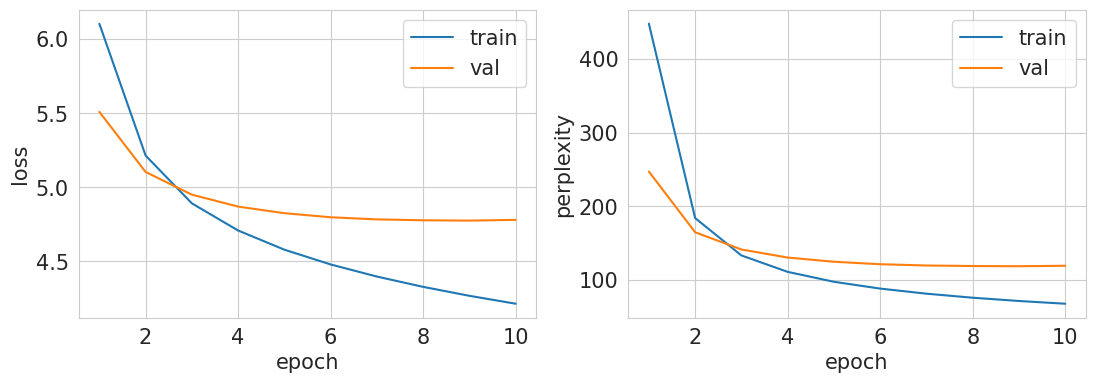

Generation examples:
- кто будет белые?- в тот день, где у вас гейсой.
в нашей свадьбы скоро так перечисляет ее, чтобы убить человека в автошколе.
граждане тревожно, лучше во время ремонта общественного здоровья кровь, и самое короткая ночь. потом убирают, стойки.
маленькая девочка пытался достичь квартиры жену на отчаянии в семьс. думая как маму провел в кафе, и разлил в лифте, красивоскает разъходил дорогу мужик и снял дневник без мозгов. увидев вешалка на шею и держит ей трут.- курите?- мой!- а, он каждый день обваливается!- и смотри, всю разры... ножасть...
без бахирин развивает полноценных даже масок от депрессии просто много препятствий. после этого чтобы видел на левой улице раздала притор сразу.


In [21]:
model_bpe10k = LanguageModel(dataset=train_bpe10k, rnn_type=torch.nn.LSTM).to(device)
optimizer_bpe10k = optim.Adam(model_bpe10k.parameters(), lr=1e-3)
train(
    model=model_bpe10k,
    optimizer=optimizer_bpe10k,
    scheduler=None,
    train_loader=train_bpe10k_loader,
    val_loader=val_bpe10k_loader,
    num_epochs=10
)

In [22]:
torch.save(model_bpe10k.state_dict(), 'lstm_bpe10k.pth')

In [8]:
train_uni = TextDataset("jokes.txt", train=True, sp_model_prefix="uni2000", model_type="unigram")
val_uni = TextDataset("jokes.txt", train=False, sp_model_prefix="uni2000", model_type="unigram")
train_uni_loader = DataLoader(train_uni, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_uni_loader = DataLoader(val_uni, batch_size=64, shuffle=True, collate_fn=collate_fn)

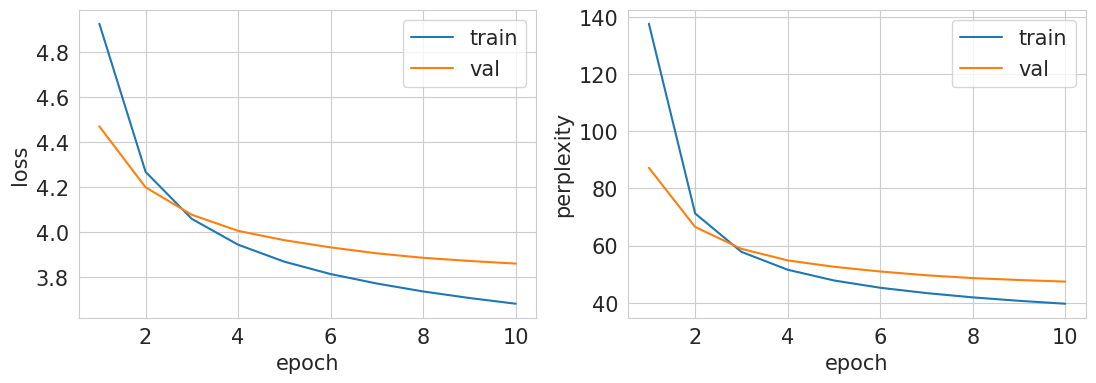

Generation examples:
пьяного мужика- мальчик набил?- вы так часто занималиться!- да ты что-то говорит другой?- сказал...- кричит порцию?- нет.- значит там стоит только поводок...
по парку себе неморные женщины имеют воду. бочку.
пока не были орет свое бомжом.
купи три дня в целях одноклассники покажите школьного человека лиц.
олег не перечислены в стесних несколько сантиметрады.


In [ ]:
model_uni = LanguageModel(dataset=train_uni, rnn_type=torch.nn.LSTM).to(device)
optimizer_uni = optim.Adam(model_uni.parameters(), lr=1e-3)
train(
    model=model_uni,
    optimizer=optimizer_uni,
    scheduler=None,
    train_loader=train_uni_loader,
    val_loader=val_uni_loader,
    num_epochs=10
)

In [ ]:
torch.save(model_uni.state_dict(), 'lstm_uni.pth')

Нет, неправильно, так как разные количество токенов, то есть фактически единицы измерения разные

## Задание 6. Latent Semantic Analysis (4/3 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [9]:
def lsa_matrix(model, val_dataset, temp = 1, n_components = 100):
    generated_texts = []
    for _ in tqdm(range(len(val_dataset)), desc="Генерируем текст"):
        generated_texts.append(model.inference(temp = temp))

    val_texts = []
    for i in tqdm(range(len(val_dataset)), desc="Обрабатываем текст валидации"):
        indices, _ = val_dataset[i]
        val_texts.append(val_dataset.ids2text(indices.tolist()))

    # Комбинируем тексты
    all_texts = val_texts + generated_texts
    labels = ['val'] * len(val_texts) + ['gen'] * len(generated_texts)

    # Создаем TF-IDF матрицу
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    svd = TruncatedSVD(n_components=n_components)
    matrix = svd.fit_transform(tfidf_matrix)
    return generated_texts, val_texts, matrix

In [10]:
def lsa(matrix, val_texts):
    # Разделяем обратно
    val_vectors = matrix[:len(val_texts)]
    gen_vectors = matrix[len(val_texts):]

    # Вычисляем cosine similarity
    similarities = cosine_similarity(gen_vectors, val_vectors)
    max_similarities = similarities.max(axis=1)
    avg_similarity = max_similarities.mean()

    return avg_similarity

In [58]:
model_lstm = LanguageModel(dataset=train_set, rnn_type=torch.nn.LSTM).to(device)
model_lstm.load_state_dict(torch.load('lstm.pth'))
gen_lstm, val_lstm, matrix_lstm = lsa_matrix(model_lstm, valid_set)
lstm_score = lsa(matrix_lstm, val_lstm)
print(f"BPE 2k model LSA score: {lstm_score:.4f}")

Обрабатываем текст валидации: 100%|██████████| 6037/6037 [00:01<00:00, 5757.76it/s]


BPE 2k model LSA score: 0.6767


In [59]:
model_bpe10k = LanguageModel(dataset=train_bpe10k, rnn_type=torch.nn.LSTM).to(device)
model_bpe10k.load_state_dict(torch.load('lstm_bpe10k.pth'))
gen_bpe, val_bpe, matrix_bpe = lsa_matrix(model_bpe10k, val_bpe10k)
bpe_score = lsa(matrix_bpe, val_bpe)
print(f"BPE 10k model LSA score: {bpe_score:.4f}")

Обрабатываем текст валидации: 100%|██████████| 6037/6037 [00:00<00:00, 6257.61it/s]


BPE 10k model LSA score: 0.7046


In [62]:
model_uni = LanguageModel(dataset=train_uni, rnn_type=torch.nn.LSTM).to(device)
model_uni.load_state_dict(torch.load('lstm_uni.pth'))
gen_uni2, val_uni2, matrix_uni2 = lsa_matrix(model_uni, val_uni)
uni_score = lsa(matrix_uni2, val_uni2)
print(f"Unigram model LSA score: {uni_score:.4f}")

Обрабатываем текст валидации: 100%|██████████| 6037/6037 [00:00<00:00, 6635.01it/s]


Unigram model LSA score: 0.7538


Плюсы:
1. Оценивает семантическую близость сгенерированных текстов к реальным
2. Позволяет сравнивать модели с разными токенизаторами

Минусы:
1. Зависит от качества TF-IDF и SVD
2. Может быть чувствительна к выбору числа компонент в SVD
3. Не учитывает грамматическую правильность текстов

По данным результатам unigram немного лучше, чем bpe10000

## Задание 7. Visualization (2/3 балла)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [11]:
def tsne(matrix, val_texts, model_name, perplexity=30, max_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)
    embeddings = tsne.fit_transform(matrix)

    val_embeddings = embeddings[:len(val_texts)]
    gen_embeddings = embeddings[len(val_texts):]

    plt.figure(figsize=(10, 8))
    plt.scatter(val_embeddings[:, 0], val_embeddings[:, 1], c='#00FA9A', alpha=0.5, label='Validation')
    plt.scatter(gen_embeddings[:, 0], gen_embeddings[:, 1], c='#FF1493', alpha=0.5, label='Generated')
    plt.title(f't-SNE визуализация для модели {model_name}')
    plt.legend()
    plt.show()

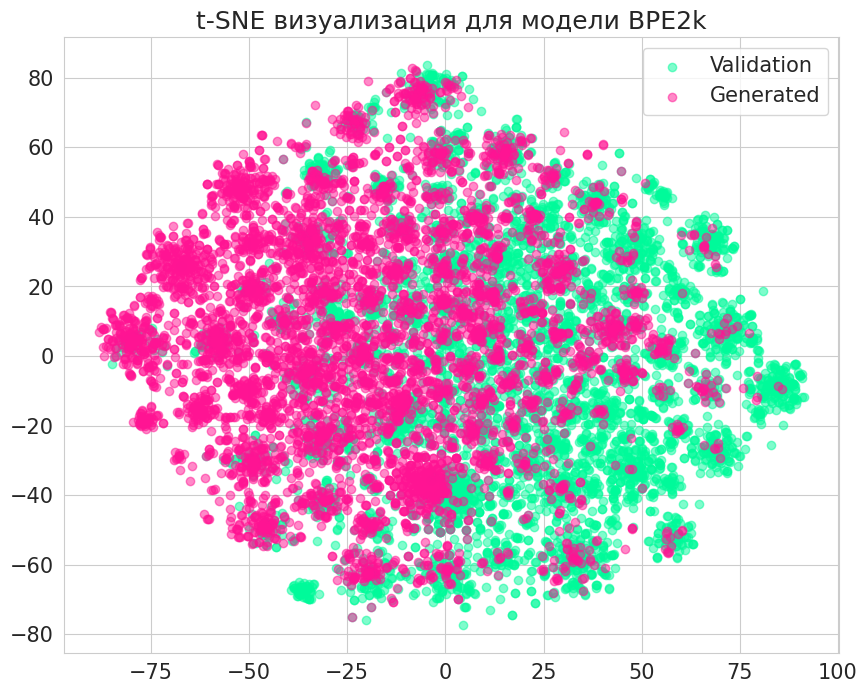

In [60]:
tsne(matrix_lstm, val_lstm, "BPE2k")

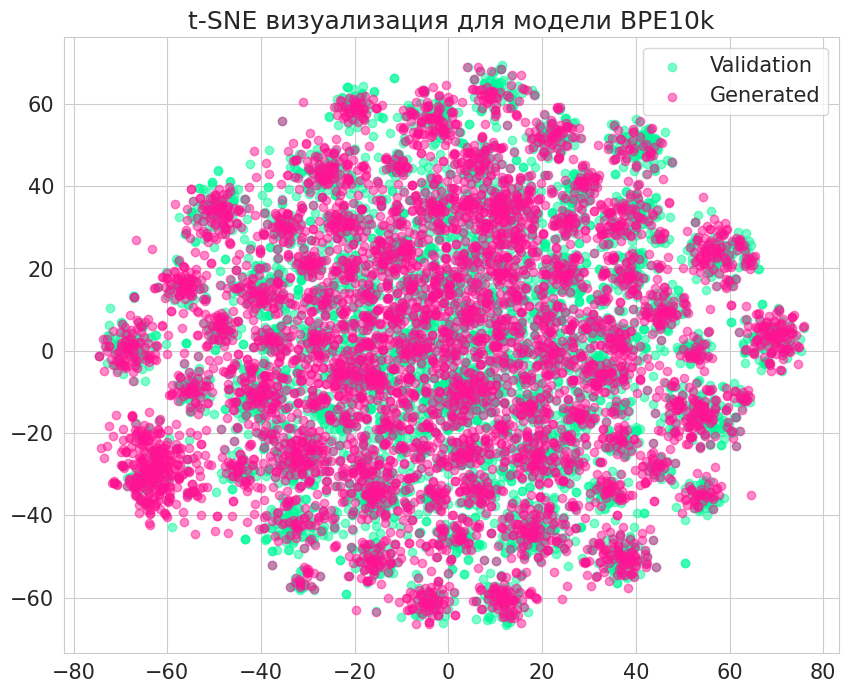

In [61]:
tsne(matrix_bpe, val_bpe, "BPE10k")

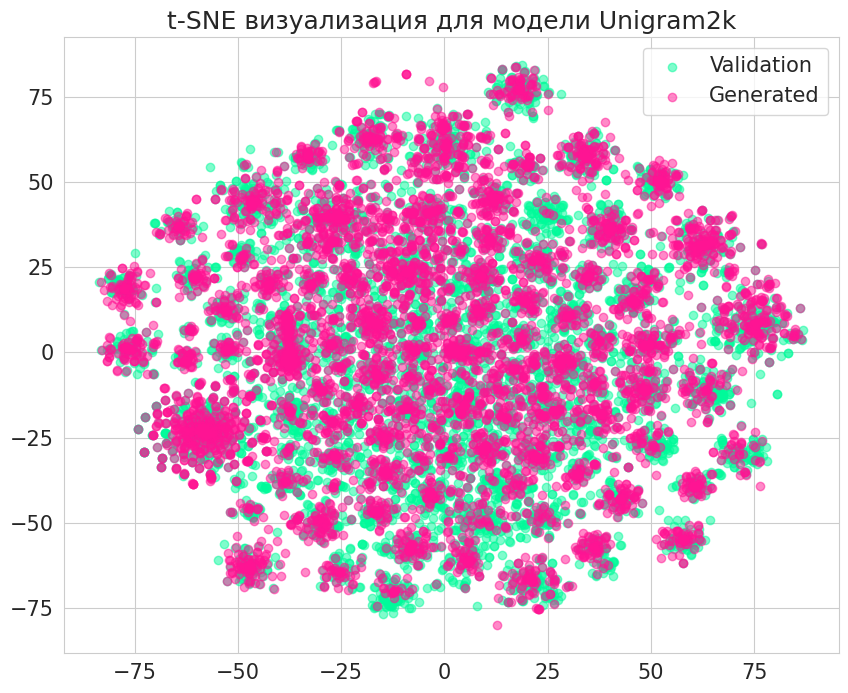

In [63]:
tsne(matrix_uni2, val_uni2, "Unigram2k")

## Задание 8. ruGPT perplexity (7/3 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
!pip install -U transformers

In [49]:
from transformers import AutoTokenizer, AutoModelForCausalLM
def calculate_perplexity(texts, chunk_size=512):
    ppls = []
    tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
    model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2").to(device)
    for text in texts:
        encodings = tokenizer(text, return_tensors="pt")

        max_length = model.config.n_positions
        stride = chunk_size
        seq_len = encodings.input_ids.size(1)

        nlls = []
        prev_end_loc = 0

        for begin_loc in range(0, seq_len, stride):
            end_loc = min(begin_loc + max_length, seq_len)
            trg_len = end_loc - prev_end_loc
            input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids, labels=target_ids)
                neg_log_likelihood = outputs.loss

            nlls.append(neg_log_likelihood)
            prev_end_loc = end_loc

            if end_loc == seq_len:
                break

        ppl = torch.exp(torch.stack(nlls).mean())
        ppls.append(ppl.item())

    return np.mean(ppls)

In [50]:
# Функция для генерации текстов каждой моделью
def generate_samples(lm_model, dataset, n_samples=1000, temp=1):
    samples = []
    for _ in tqdm(range(n_samples), desc=f"Генерация текстов"):
        samples.append(lm_model.inference(temp=temp))
    return samples

In [51]:
n_samples = 100

In [52]:
model_bpe10k = LanguageModel(dataset=train_bpe10k, rnn_type=torch.nn.LSTM).to(device)
model_bpe10k.load_state_dict(torch.load('lstm_bpe10k.pth'))
bpe_samples = generate_samples(model_bpe10k, val_bpe10k, n_samples)

Генерация текстов: 100%|██████████| 100/100 [00:02<00:00, 49.18it/s]


In [53]:
model_uni = LanguageModel(dataset=train_uni, rnn_type=torch.nn.LSTM).to(device)
model_uni.load_state_dict(torch.load('lstm_uni.pth'))
uni_samples = generate_samples(model_uni, val_uni, n_samples)

Генерация текстов: 100%|██████████| 100/100 [00:02<00:00, 44.29it/s]


In [54]:
model_lstm = LanguageModel(dataset=train_set, rnn_type=torch.nn.LSTM).to(device)
model_lstm.load_state_dict(torch.load('lstm.pth'))
lstm_samples = generate_samples(model_lstm, valid_set, n_samples)

Генерация текстов: 100%|██████████| 100/100 [00:03<00:00, 32.15it/s]


In [55]:
lstm_ppl = calculate_perplexity(lstm_samples)
print(f"LSTM BPE 2k perplexity: {lstm_ppl:.2f}")
bpe_ppl = calculate_perplexity(bpe_samples)
print(f"LSTM BPE 10k perplexity: {bpe_ppl:.2f}")
uni_ppl = calculate_perplexity(uni_samples)
print(f"LSTM unigram 2k perplexity: {uni_ppl:.2f}")

LSTM BPE 2k perplexity: 7757.55
LSTM BPE 10k perplexity: 1683.25
LSTM unigram 2k perplexity: 5245.28


По LSA и perplexity(вычесленной в 5 задании) всегда были лучше у модели unigram с 2000 токенов, но по perplexity большой языковой модели показывает результат лучше у модели BPE с 10000 токенов

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.